<a href="https://colab.research.google.com/github/caccioppoli/etas_optimization/blob/main/etas_op.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing libraries

In [24]:
import numpy as np
import pandas as pd
import pickle as pkl
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import datetime
from math import radians, cos, sin, asin, sqrt
import time
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading instrumental catalog

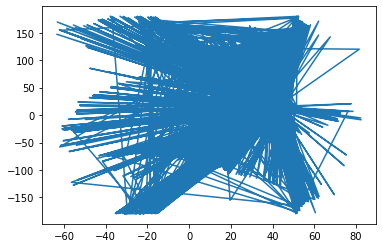

In [22]:
with open("drive/MyDrive/Colab Notebooks/cat_italia.txt","r") as infile, open("drive/MyDrive/Colab Notebooks/cat_italia_conv.txt",'w') as outfile:
    for line in infile:
      outfile.write(" ".join(line.split()).replace('|',' '))
      outfile.write("\n")

# converto e memorizzo in secondi la data 

sdate = np.genfromtxt("drive/MyDrive/Colab Notebooks/cat_italia_conv.txt",dtype="str",delimiter=" ",usecols=(1))
startdate = datetime.strptime('1985-01-02T18:39:30.740000',"%Y-%m-%dT%H:%M:%S.%f")
seconds = []
for time in sdate:
  date = datetime.strptime(time,"%Y-%m-%dT%H:%M:%S.%f")
  temp = (date - startdate).total_seconds()
  seconds.append(temp)

# converto e memorizzo le altre grandezze del catalogo

latitude = np.genfromtxt("drive/MyDrive/Colab Notebooks/cat_italia_conv.txt",dtype="float",delimiter=" ",usecols=(2))
longitude = np.genfromtxt("drive/MyDrive/Colab Notebooks/cat_italia_conv.txt",dtype="float",delimiter=" ",usecols=(3))
depth = np.genfromtxt("drive/MyDrive/Colab Notebooks/cat_italia_conv.txt",dtype="float",delimiter=" ",usecols=(4))
magnitude = np.genfromtxt("drive/MyDrive/Colab Notebooks/cat_italia_conv.txt",dtype="float",delimiter=" ",usecols=(10))

plt.plot(latitude,longitude)
plt.show()


#Defining functions

In [19]:
# Calculate the great circle distance in kilometers between two points on the earth (specified in decimal degrees)

def distance(s_lat, e_lat, s_lng, e_lng):
  # approximate radius of earth in km
  R = 6373.0
  s_lat = s_lat*np.pi/180.0                      
  s_lng = np.deg2rad(s_lng)     
  e_lat = np.deg2rad(e_lat)                       
  e_lng = np.deg2rad(e_lng)  
  d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2
  return 2 * R * np.arcsin(np.sqrt(d))

#Declustering Space-Time Window

In [17]:
lencat = len(seconds)
print('catalog length:',lencat,'events')
filemain = open("drive/MyDrive/Colab Notebooks/mainshocks.txt", "w")
fileafter = open("drive/MyDrive/Colab Notebooks/aftershocks.txt", "w")
filefore = open("drive/MyDrive/Colab Notebooks/foreshocks.txt", "w")

####  DEFINING PARAMETERS ####

magnitude_threshold = 6
time_limit_fore = 7*24*3600 #within 7 days before
time_limit_after = 3*24*3600 #within 3 days after
space_limit = 100 #within 100 km

##############################

#### DEFINING ARRAY #####

threshold_after = np.zeros(4)
threshold_after[0] = 2.5
threshold_after[1] = 3
threshold_after[2] = 3.5
threshold_after[3] = 4

threshold_time = np.zeros(3)
threshold_time[0] = 1*24*3600
threshold_time[1] = 3*24*3600
threshold_time[2] = 10*24*3600

threshold_space = np.zeros(5)
threshold_space[0] = 3
threshold_space[1] = 10
threshold_space[2] = 20
threshold_space[3] = 40

#########################

#### SEARCHING FOR MAINSHOCKS ####

for event in range(1,lencat):
  if(magnitude[event]>=magnitude_threshold and magnitude[event]<magnitude_threshold+1):
    for fore in range(event-1,-1,-1):     
      dt = seconds[event]-seconds[fore]
      if(dt>time_limit_fore):
        main_index = True
        break
      elif(dt<time_limit_fore and magnitude[fore]>=magnitude_threshold):
        dr = distance(latitude[event],latitude[fore],longitude[event],longitude[fore])
        if (dr>space_limit):
          main_index = True
          break
    for after in range(event+1,lencat): 
      dt = seconds[event]-seconds[after]
      if(dt>time_limit_after):
        main_index = True
        break
      elif(dt<time_limit_after and magnitude[after]>=magnitude_threshold):
        dr = distance(latitude[event],latitude[after],longitude[event],longitude[after])
        if (dr>space_limit):
          main_index = True
          break
      
    filemain.write(str(seconds[event])+" "+str(magnitude[event])+" "+str(latitude[event])+" "+str(longitude[event])+"\n")

#################################

#### BUILDING AFTERSHOCK & FORESHOCKS MATRIX ####

    nafter = np.zeros([4,3,5],dtype=np.int8)
    nfore = np.zeros([4,3,5],dtype=np.int8)

    threshold_space[4]=0.01*np.power(10,0.5*magnitude[event])
    
    if(main_index == True):
      for after in range(event+1,lencat): 
        dt = seconds[after]-seconds[event]
        dr = distance(latitude[event],latitude[after],longitude[event],longitude[after])
        for mag_aft in range(4):
          for time_aft in range(3):
            for space_aft in range(5):
              if(magnitude[after]>=threshold_after[mag_aft]):
                if(dt<threshold_time[time_aft]):
                  if(dr<threshold_space[space_aft]):
                    nafter[mag_aft,time_aft,space_aft]+=1
      
      for fore in range(event-1,-1,-1):  
        dt = seconds[event]-seconds[fore]
        dr = distance(latitude[event],latitude[fore],longitude[event],longitude[fore])
        for mag_aft in range(4):
          for time_aft in range(3):
            for space_aft in range(5):
              if(magnitude[fore]>=threshold_after[mag_aft]):
                if(dt<threshold_time[time_aft]):
                  if(dr<threshold_space[space_aft]):
                    nfore[mag_aft,time_aft,space_aft]+=1

###################################################

#### WRITING AFTERSHOCK & FORESHOCKS MATRIX ####

      fileafter.write(str(nafter)+"\n")
      filefore.write(str(nfore)+"\n")

################################################








catalog length: 104683 events


KeyboardInterrupt: ignored

#Declustering Baiesi